# Anomaly detection in Time Series data

In the other notebook, we briefly showed methods of anomaly detection. Here, we will show approaches to anomaly detection in time series data. For that we will use sensor data from a water pump. The task is to find anomalies such that we can predict when the water pump is about to fail.  
As usual, we will start by importing the necessary modules and data for the first steps.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/sensor.csv', index_col=0)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


As many real-life datasets, this dataset is likely to need some cleaning. Let's do that first.

In [3]:
# Drop duplicates
df_orig_clean = df.drop_duplicates()
# Convert timestamp column to datetime object
df_orig_clean["date"] = pd.to_datetime(df_orig_clean["timestamp"])
df_orig_clean = df_orig_clean.drop("timestamp", axis=1)
df_orig_clean.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,date
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:00:00
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:01:00
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,2018-04-01 00:02:00
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,2018-04-01 00:03:00
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,2018-04-01 00:04:00


In [4]:
# Helper function to calculate percentage missing data
def calc_missing_data(df):
    percent_missing = df.isnull().mean() * 100

    return percent_missing[percent_missing > 0].sort_values(ascending=False)


calc_missing_data(df_orig_clean).head(10)

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
sensor_08      2.317992
sensor_06      2.177741
sensor_09      2.085603
sensor_01      0.167484
sensor_30      0.118464
dtype: float64

We can see that sensor 15 is not picking up any data. We can therefore drop it.  
Also, in preparation for upcoming analyses, we want to impute some of the missing data in the remaining sensors. We will use the mean strategy. We impute because we don't want to lose the remaining good data which we would otherwise. Finally, working with scaled values will be necessary, so we will standard scale them now. More on that later.

In [5]:
# Drop faulty sensor
df_orig_clean = df_orig_clean.drop("sensor_15", axis=1)
# Impute
df_orig_clean.fillna(df_orig_clean.mean(), inplace=True)

C:\Users\miche\AppData\Local\Temp\ipykernel_30128\1160276397.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_orig_clean.fillna(df_orig_clean.mean(), inplace=True)
C:\Users\miche\AppData\Local\Temp\ipykernel_30128\1160276397.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_orig_clean.fillna(df_orig_clean.mean(), inplace=True)


In [6]:
# Scale
df_clean = df_orig_clean.drop(["machine_status", "date"], axis=1)
col_names = df_clean.columns

scaler = StandardScaler()
df_orig_clean_scaled = scaler.fit_transform(df_clean)
df_clean = pd.DataFrame(df_orig_clean_scaled, columns=col_names)
df_clean.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,0.231450,-0.151675,0.639386,1.057675,0.303443,0.177097,-0.042091,0.132586,0.181964,0.122858,...,-0.358970,-0.176799,-0.260520,1.759633,0.185888,-0.588642,0.086297,0.553138,1.140144,-0.012402
1,0.231450,-0.151675,0.639386,1.057675,0.303443,0.177097,-0.042091,0.132586,0.181964,0.122858,...,-0.358970,-0.176799,-0.260520,1.759633,0.185888,-0.588642,0.086297,0.553138,1.140144,-0.012402
2,0.180129,-0.072613,0.639386,1.093565,0.334786,0.008647,-0.082656,0.089329,0.207112,0.101892,...,-0.358970,-0.200379,-0.285516,1.737092,0.204388,-0.588641,0.061668,0.522906,1.107156,0.009499
3,0.219228,-0.151675,0.627550,1.093564,0.260045,0.207693,-0.086035,0.185835,0.246628,0.136839,...,-0.384354,-0.271121,-0.310513,1.692010,0.204388,-0.588642,0.061668,0.507790,1.090664,0.004024
4,0.182573,-0.138499,0.639386,1.093564,0.317909,0.184568,-0.069133,0.169195,0.246628,0.136839,...,-0.384354,-0.223959,-0.335509,1.714550,0.241389,-0.533219,0.089816,0.492674,1.123650,-0.012402


## EDA

We are now ready to visualize the data. Let's plot it across time, marking the moments at which the machine_status is "BROKEN" with red Xs. This way we can better understanding the relationship of the sensor data to the actual functionality status of the pump.
More specifically, we can now plot when exactly the machine_status was broken for each sensor over time. Let us also add the rolling average and standard deviation in anticipation for stationarity and autocorrelation analyses that we will add later.

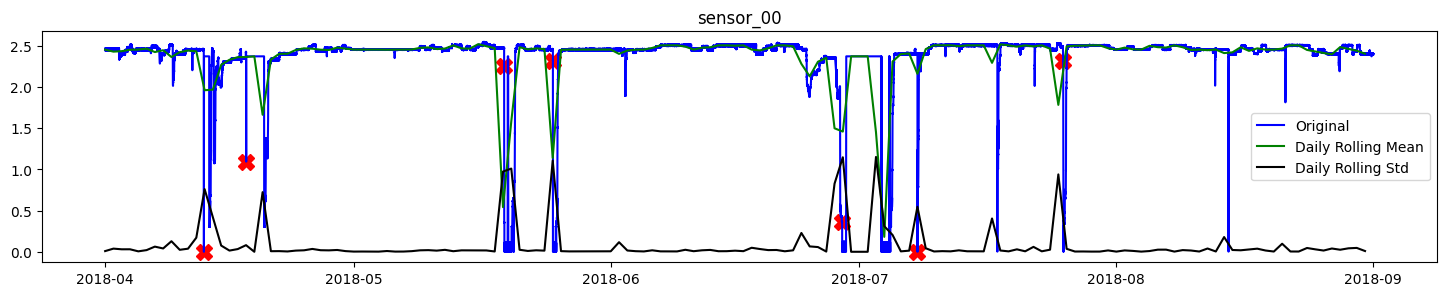

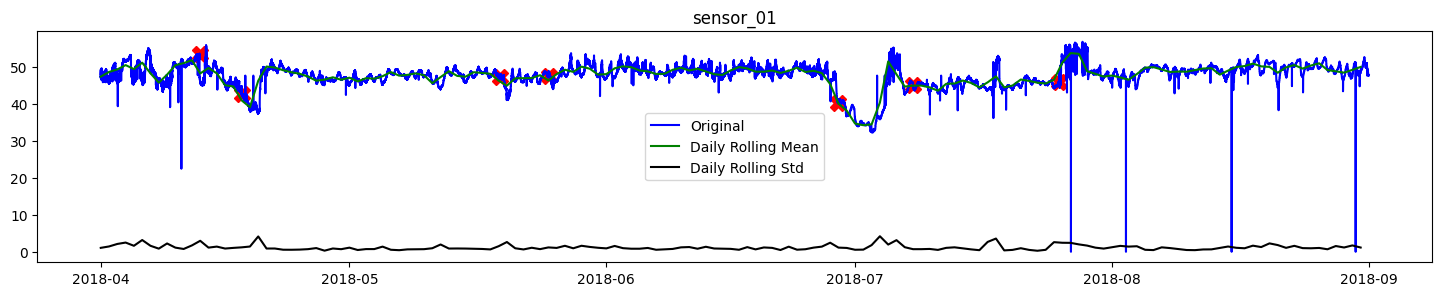

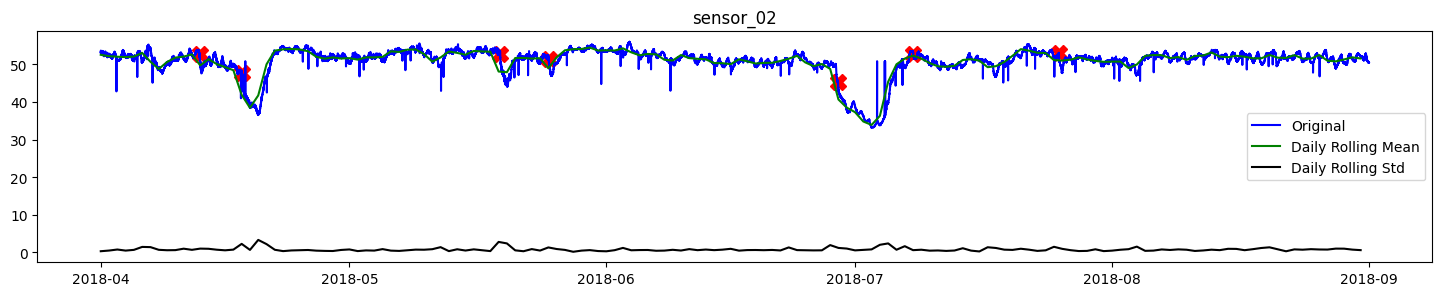

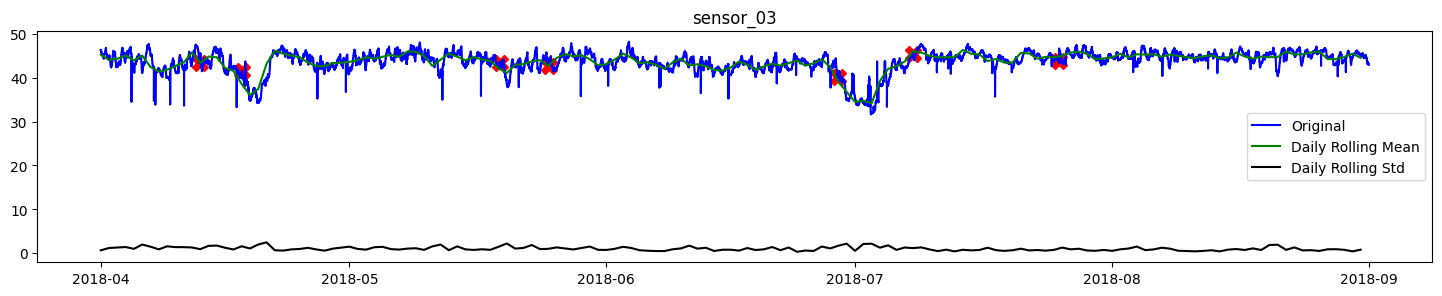

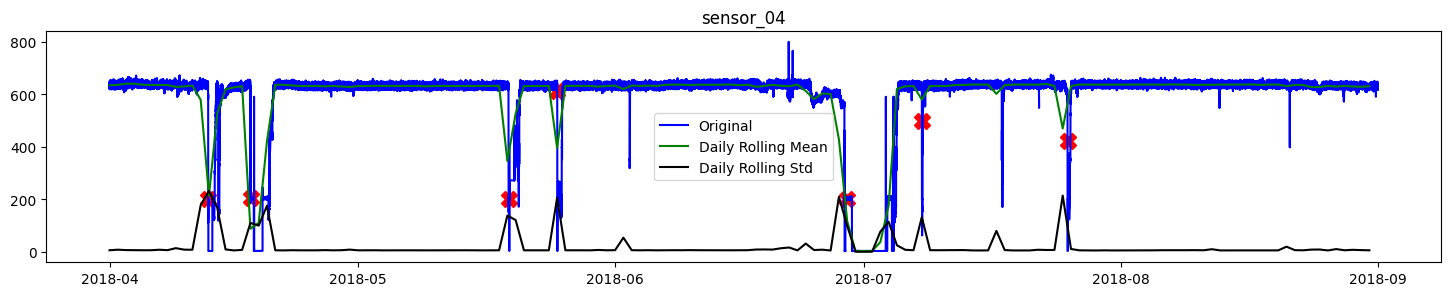

In [7]:
# Preparations for plotting
df_orig_clean_w_dtidx = df_orig_clean.set_index("date")
broken_states = df_orig_clean_w_dtidx[df_orig_clean_w_dtidx["machine_status"] == "BROKEN"]
sensors_with_broken = df_orig_clean_w_dtidx.drop(["machine_status"], axis=1).columns

# Get the daily rolling average and standard deviation
rollmean = (
    df_orig_clean_w_dtidx.select_dtypes(include=["number"]).resample(rule="D").mean()
)
rollstd = (
    df_orig_clean_w_dtidx.select_dtypes(include=["number"]).resample(rule="D").std()
)

# For brevity we only plot the first 5 sensors
for idx, sensor_broken in enumerate(sensors_with_broken):
    if idx == 5:
        break
    plt.figure(figsize=(18, 3))
    plt.plot(
        broken_states[sensor_broken],
        linestyle="none",
        marker="X",
        color="red",
        markersize=12,
    )
    plt.plot(df_orig_clean_w_dtidx[sensor_broken], color="blue", label="Original")
    plt.plot(
        rollmean[sensor_broken], color="green", label="Daily Rolling Mean"
    )
    plt.plot(rollstd[sensor_broken], color="black", label="Daily Rolling Std")
    plt.legend(loc="best")
    plt.title(sensor_broken)
    plt.show()


Sensor 00 clearly shows a pattern that is consistently observer for the vast majority of sensors: the "broken" state occurs when there are large deviations or completely failure of sensor readings. This gives us some intuition on how each of the sensor readings behaves when the pump is broken.

# PCA

In time series analyses, it is important that the data is stationary and has no autocorrelation.  
*Stationarity* refers to the behavior where the mean and standard deviation of the data changes over time, the data with such behavior is considered not stationary.  
*Autocorrelation* refers to the behavior of the data where the data is correlated with itself in a different time period.  
Looking at our rolling average and standard deviation as a first indication for sensor 04, we can notice that the data actually looks pretty stationary because the rolling mean and standard deviation do not seem to change much over time except during the downtime of the pump. This is indeed expected and was the case for most of the sensors. Note though that if stationarity or autocorrelation assumptions are not given, the data must be made stationary before modelling otherwise model performance will suffer dramatically or be misleading.  
Another good way to check for autocorrelation and stationarity are the Dickey-Fuller test, KPSS test and ACF plots. For more in-depth on that [see my other time-series project](https://github.com/MichlF/projects/tree/main/data_science/temperature_forecast).

Since it is computationally expensive to train models with a lot of features and since it is possible that many features do not actually contribute much variance, one way to improve model performance and efficiency of training is to reduce dimensionality. A method that can be applied is *Principal Component Analysis*, *PCA* in short, to extract a limited number of features to continue working with. It is imperative that before applying PCA, data must be scaled and standardized because PCA algorithms often use distance measures.  
Looking at our graphs from earlier, it is clear that this is not given for the dataset used here. So let's use `sklearn`'s functions to scale and standardize the dataset (`StandardScaler`) and only then perform PCA.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

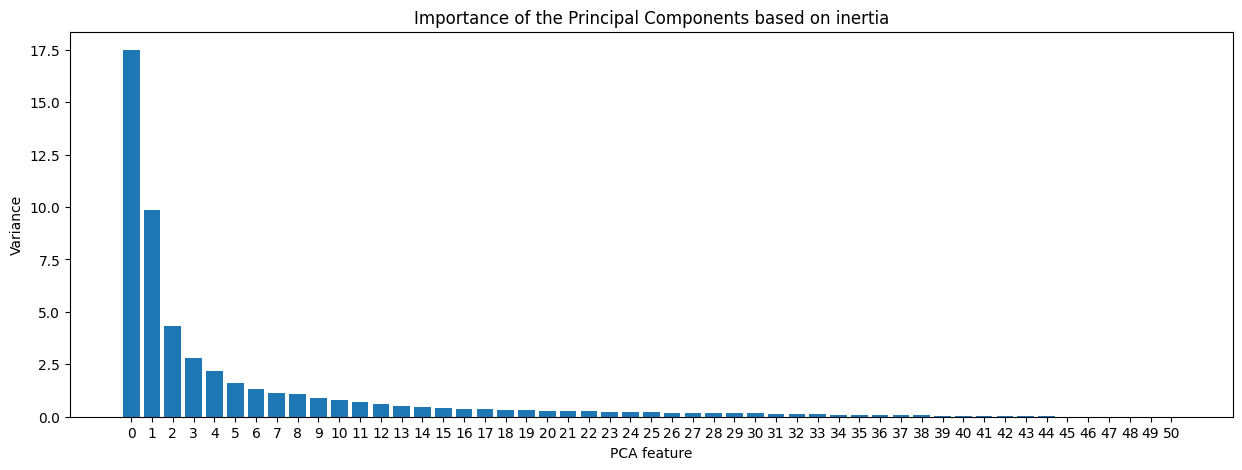

In [9]:
# Apply PCA and plot the results
X = df_clean[sensors_with_broken]
pca = PCA()
pipeline = make_pipeline(StandardScaler(), pca)
pipeline.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(15, 5))
plt.bar(features, pca.explained_variance_)
plt.xlabel("PCA feature")
plt.ylabel("Variance")
plt.xticks(features)
plt.title("Importance of the Principal Components based on inertia")
plt.show()


Although it is often to some extent arbitrary what the cutoff level is, it appears here that particularly the first two principal components are the most important. We will therefore continue with these two components.

In [10]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
df_pca = pd.DataFrame(data=pcs, columns=["pc1", "pc2"])

In [11]:
# Double-check stationarity and autocorrelation again
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Stationarity with Dickey-Fuller
print("Stationarity tests for both components:\n", adfuller(df_pca['pc1']), "\n", adfuller(df_pca['pc2']))

Stationarity tests for both components:
 (-4.571918817410406, 0.00014547127418361647, 83, 220236, {'1%': -3.430379692585317, '5%': -2.8615531237364724, '10%': -2.5667769852919347}, -306351.9682943099) 
 (-6.998368071403316, 7.43161759549964e-10, 83, 220236, {'1%': -3.430379692585317, '5%': -2.8615531237364724, '10%': -2.5667769852919347}, -213342.52462979505)


Autocorrelation is: -7.164455110221716e-06


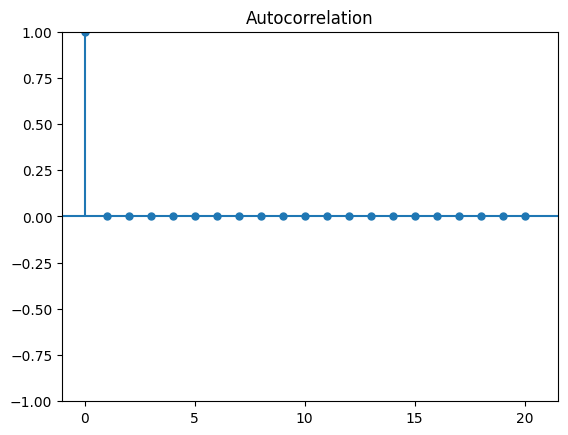

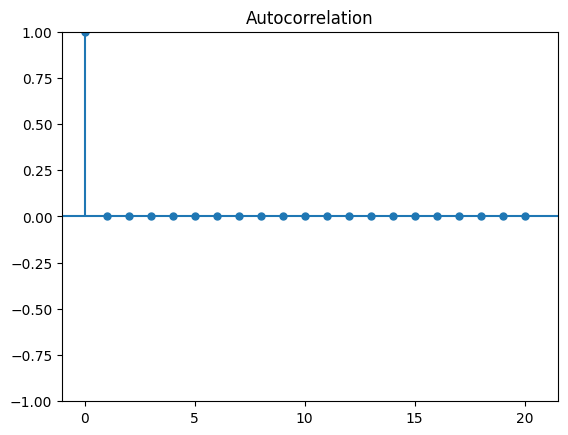

In [12]:
# Autocorrelation with pandas autocorr...
pca1 = df_pca["pc1"].pct_change()
autoco = pca1.dropna().autocorr()
print("Autocorrelation is:", autoco)
# ...and ACF
plot_acf(pca1.dropna(), lags=20, alpha=0.05)

Both stationarity and autocorrelation requirements hold for the first PCA components, so we can move on to the actual modelling.

## Modelling

We will use three different methods to detect anomalies:

1. Benchmark model: Interquartile Range (IQR)
2. K-Means clustering
3. Isolation Forest

### IQR Model

A simple interquartile range (IQR) model will act as a benchmark model for the other two approaches. For this model, we first calculate the IQR (3rd minus 1st quartile) and then the upper and lower bounds for the outliers...

In [13]:
# IQRs
q1_pc1, q3_pc1 = df_pca["pc1"].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
q1_pc2, q3_pc2 = df_pca["pc2"].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2

In [14]:
# Upper and lower bounds
lower_pc1 = q1_pc1 - (1.5 * iqr_pc1)
upper_pc1 = q3_pc1 + (1.5 * iqr_pc1)
lower_pc2 = q1_pc2 - (1.5 * iqr_pc2)
upper_pc2 = q3_pc2 + (1.5 * iqr_pc2)

Next, we filter out the data points that fall outside the upper and lower bounds and flag them as outliers before we plot them on top of the time series data.

In [15]:
# Filter outliers
df_clean["anomaly_pc1"] = (
    (df_pca["pc1"] > upper_pc1) | (df_pca["pc1"] < lower_pc1)
).astype(int).values
df_clean["anomaly_pc2"] = (
    (df_pca["pc2"] > upper_pc2) | (df_pca["pc2"] < lower_pc2)
).astype(int).values

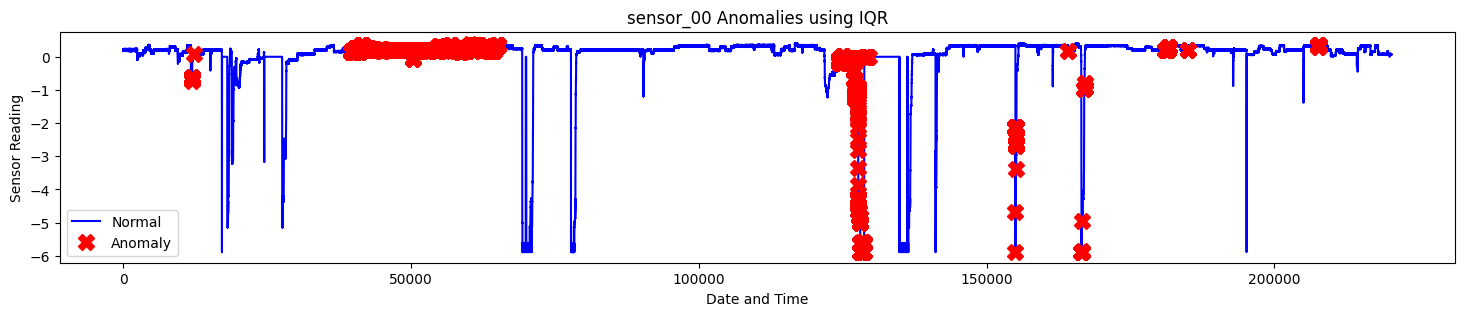

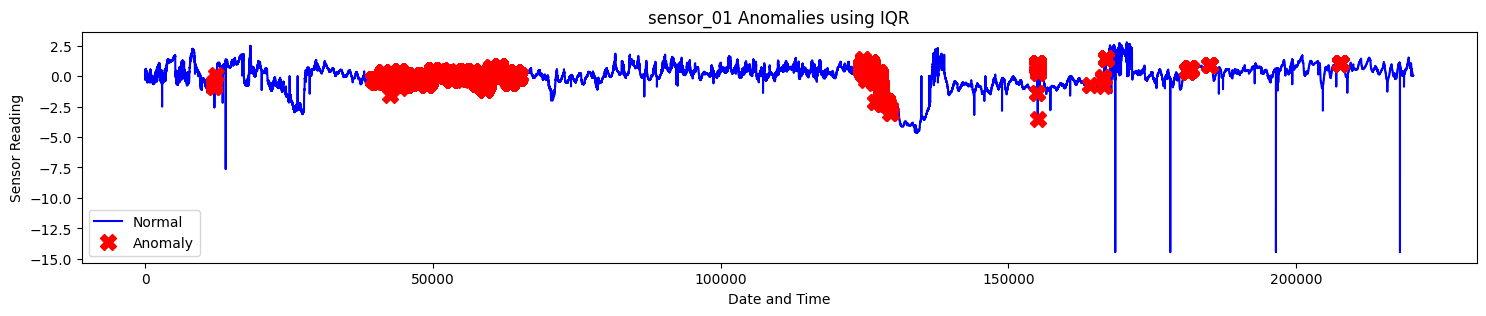

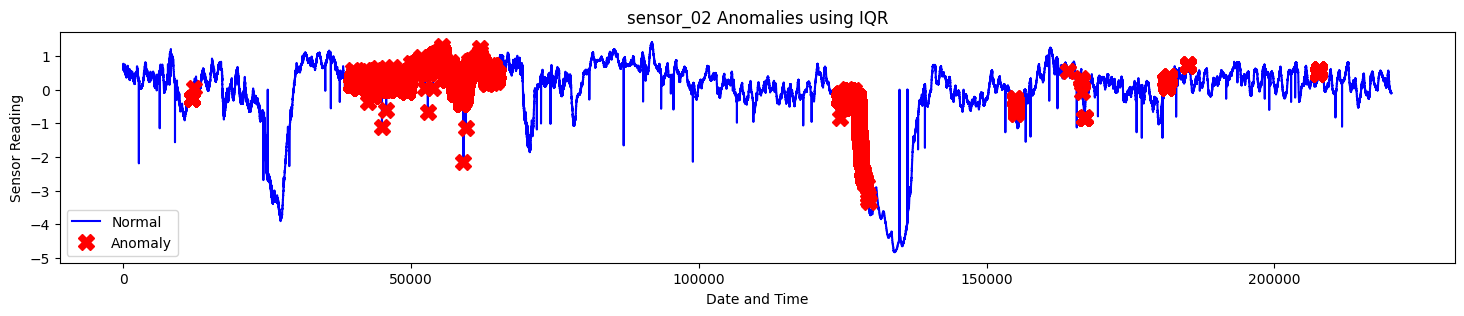

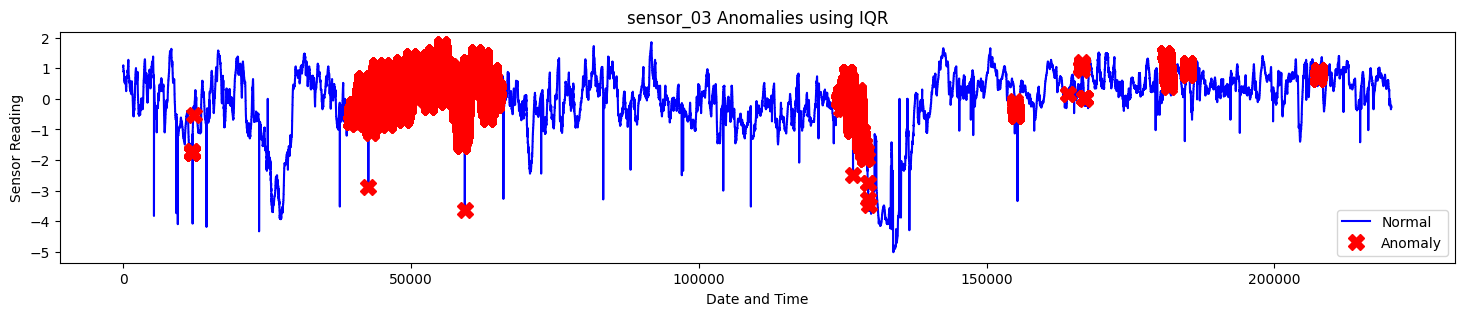

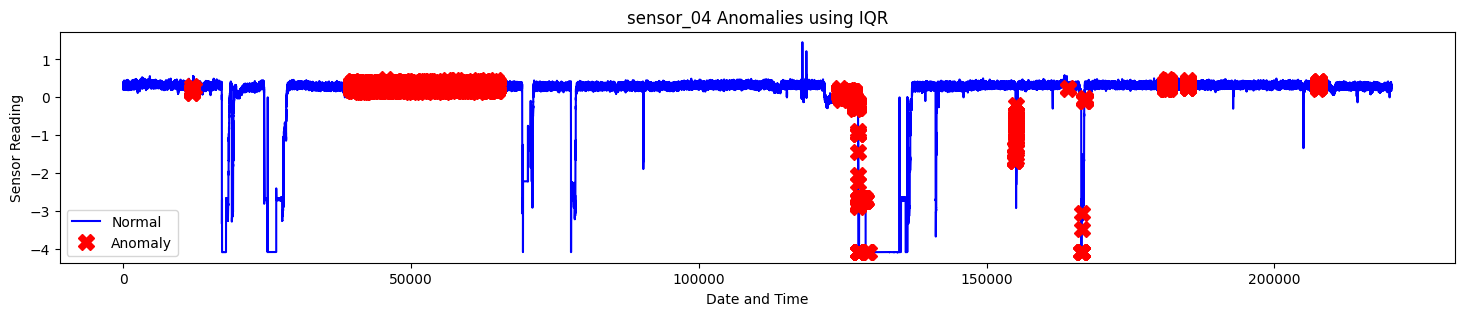

In [16]:
# Plot
anomaly = df_clean[df_clean['anomaly_pc1'] == 1] # for first PC
for idx, sensor_broken in enumerate(sensors_with_broken):
    if idx == 5:
        break
    plt.figure(figsize=(18, 3))
    plt.plot(df_clean[sensor_broken], color='blue', label='Normal')
    plt.plot(anomaly[sensor_broken], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(f'{sensor_broken} Anomalies using IQR')
    plt.legend(loc='best')
    plt.show()

This is not particularly spot on but using this approach, anomalies are often detected right before the pump breaks down. This could be a very valuable information for an operator to see and be able to shut down the pump properly before it actually goes down hard.

### KMeans model

Our next approach is K-Mean Clustering. We have used this already in the other notebook with employer salaries.  
For this approach, we first calculate the distance between each point and its nearest centroid. The largest distances are considered as anomaly. We can use `k=2` because we already know that there are 3 classes: "NORMAL", "BROKEN" and "RECOVERING"; the latter are similar and can thus be interpreted as not normal.

In [17]:
# Imports
from sklearn.cluster import KMeans

In [18]:
# Obtain the clusters
# Note: KMeans needs threadpoolctl module > version 3
kmeans = KMeans(n_clusters=2, random_state=42, n_init=5)
kmeans.fit(df_pca.values)
labels = kmeans.predict(df_pca.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

Next, we calculate the number of outliers using a predefined outliers fraction. This fraction is meant to provide information to the algorithm about the proportion of the outliers present in our data set. Situations may vary from data set to data set. However, as a starting figure, the estimation for outliers_fraction = 0.13 (i.e., 13% of df are outliers).

In [19]:
def getDistanceByPoint(data, model):
    """Calculate the distance between each point and its cluster centroid and return a pandas Series"""
    centroids = model.cluster_centers_[model.labels_ - 1]
    distances = np.linalg.norm(data - centroids, axis=1)
    
    return pd.Series(distances, index=data.index)

In [20]:
outliers_fraction = 0.13

distance = getDistanceByPoint(df_pca, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))

We can now set threshold as the minimum distance of these outliers and define an anomaly (as 1) if > threshold (otherwise 0). Finally, we can visualize the results in the manner as before.

In [21]:
threshold = distance.nlargest(number_of_outliers).min()
df_clean["anomaly_kmeans"] = (distance >= threshold).astype(int).values

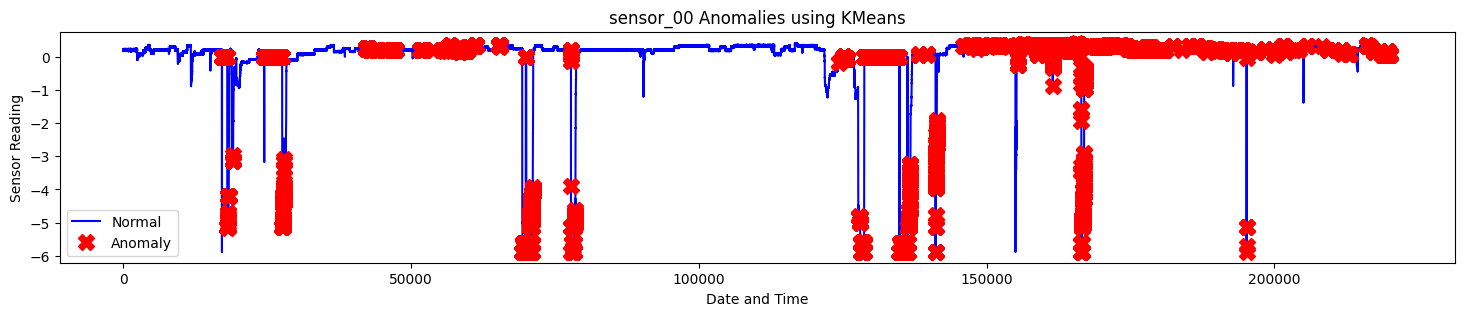

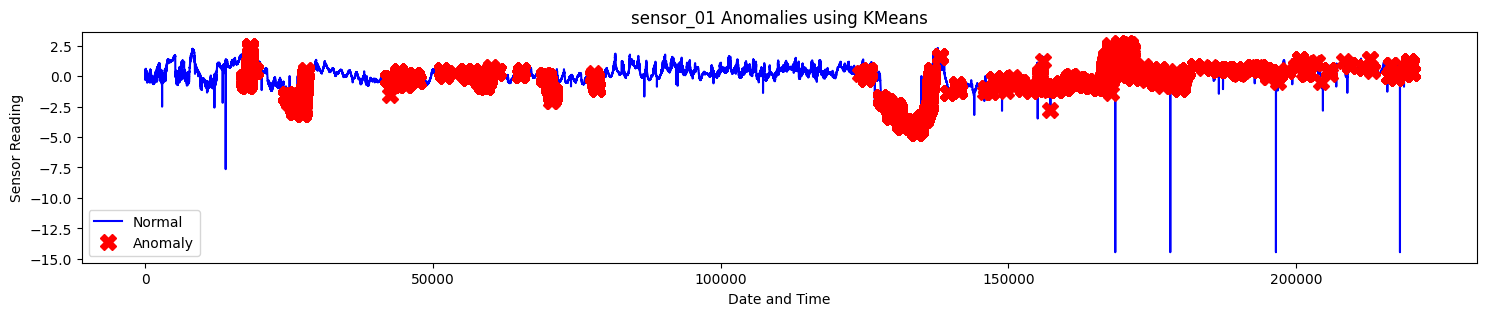

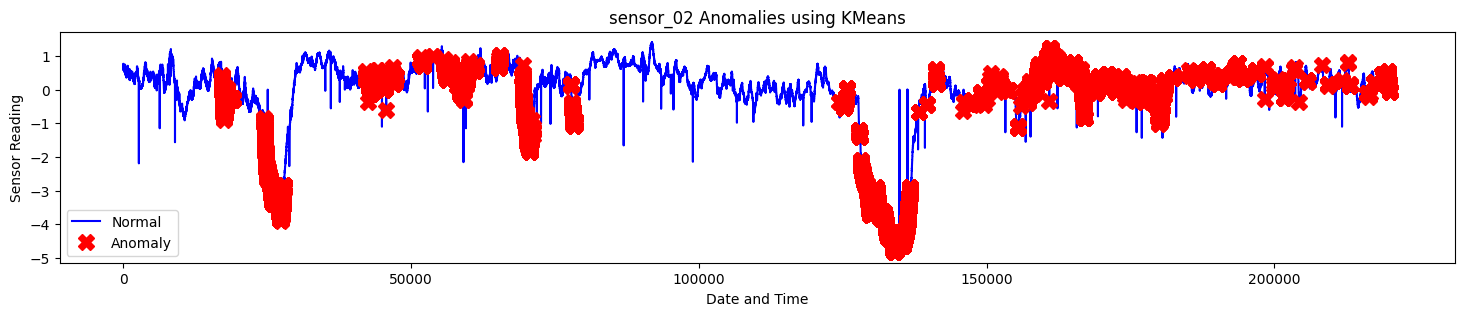

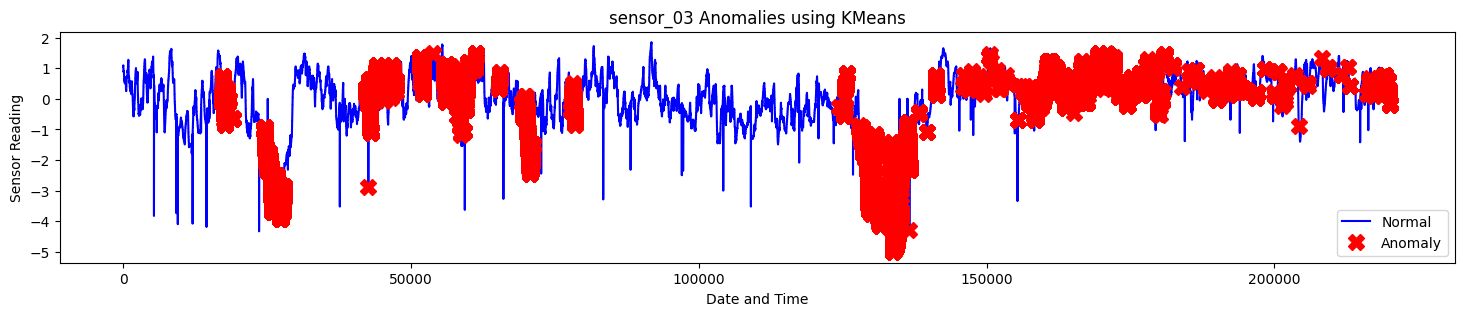

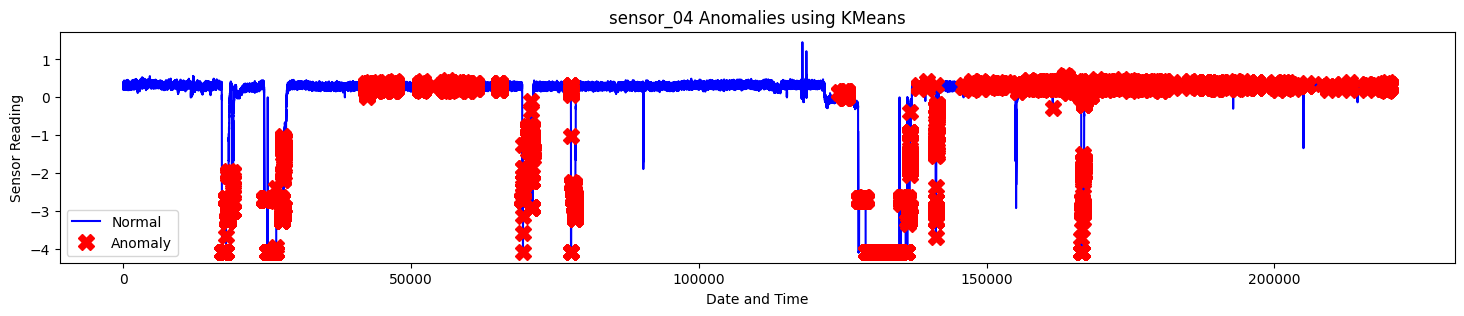

In [22]:
anomaly = df_clean[df_clean['anomaly_kmeans'] == 1]
for idx, sensor_broken in enumerate(sensors_with_broken):
    if idx == 5:
        break
    plt.figure(figsize=(18, 3))
    plt.plot(df_clean[sensor_broken], color='blue', label='Normal')
    plt.plot(anomaly[sensor_broken], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(f'{sensor_broken} Anomalies using KMeans')
    plt.legend(loc='best')
    plt.show()

This approach seems to be a more fine-grained and thus better in detecting anomalies.

## Isolation Forest model

As a final approach, we can use the Isolation Forest algorithm. The hard work has mostly been already done. So we just repeat the last few steps of the KMeans approach.

In [23]:
# Imports
from sklearn.ensemble import IsolationForest

In [24]:
outliers_fraction = 0.13

model = IsolationForest(contamination=outliers_fraction)
model.fit(df_pca.values)
df_clean["anomaly_isoforest"] = pd.Series(
    model.predict(df_pca.values)
).values

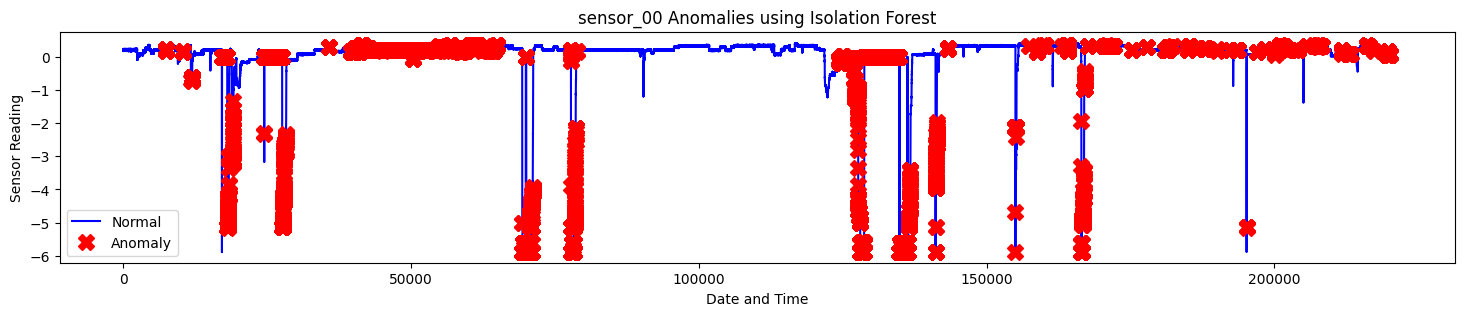

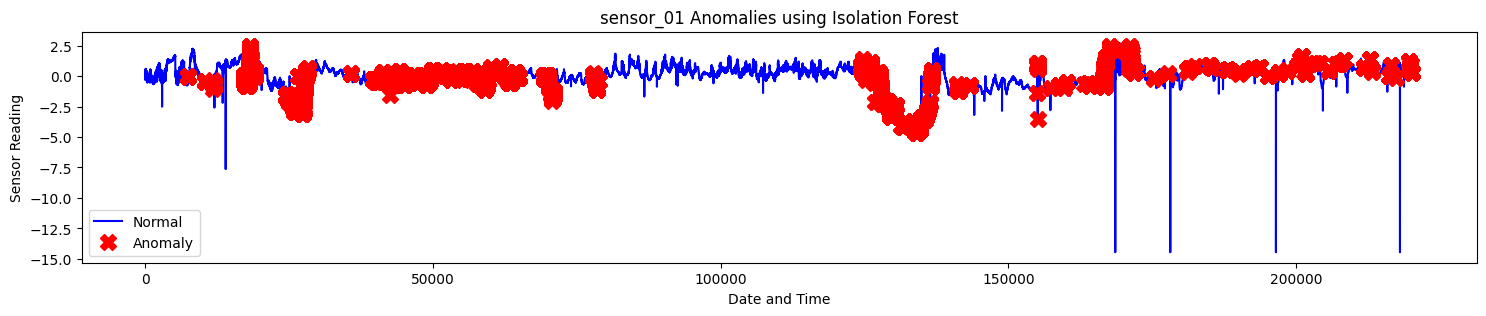

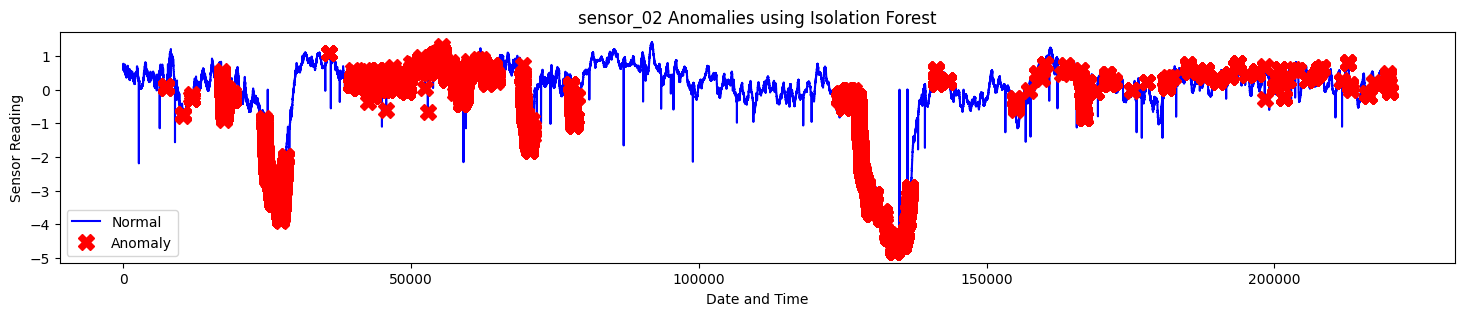

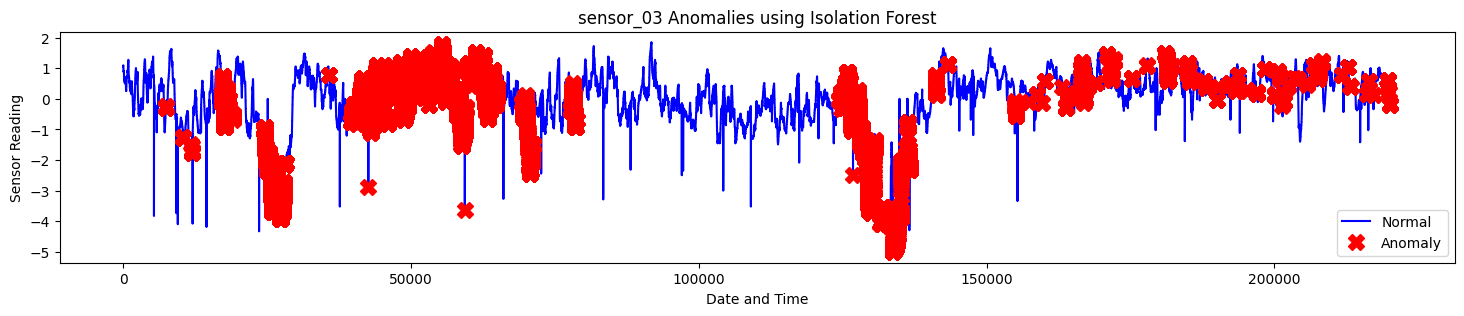

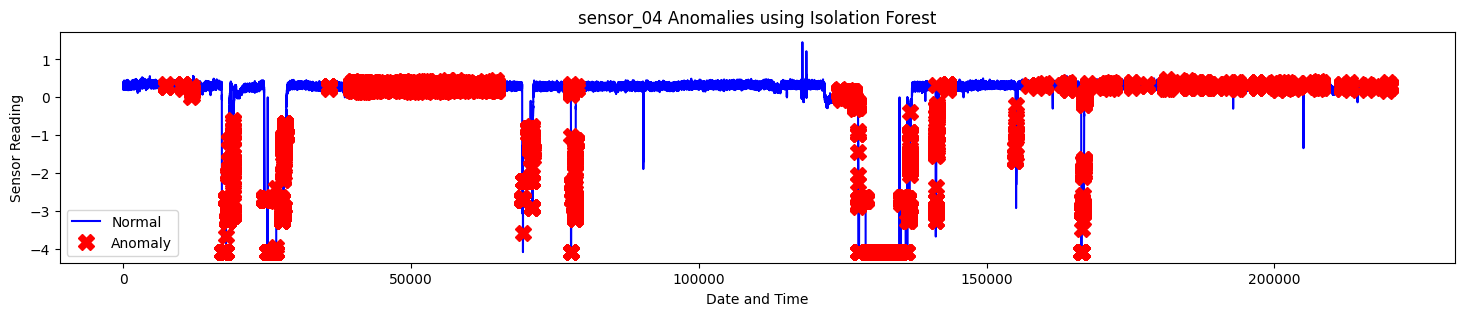

In [25]:
anomaly = df_clean[df_clean['anomaly_isoforest'] == -1] # Note: isolation forest defines an anomaly as -1
for idx, sensor_broken in enumerate(sensors_with_broken):
    if idx == 5:
        break
    plt.figure(figsize=(18, 3))
    plt.plot(df_clean[sensor_broken], color='blue', label='Normal')
    plt.plot(anomaly[sensor_broken], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
    plt.xlabel('Date and Time')
    plt.ylabel('Sensor Reading')
    plt.title(f'{sensor_broken} Anomalies using Isolation Forest')
    plt.legend(loc='best')
    plt.show()

Visual inspection makes a final judgment regarding which is the better model hard, especially among the last two. But it appears that all models catch quite a few of the same anomalies.

## Model Evaluation

The next step should be to evaluate the models but before we can do that we will first have to define anomalies uniformly among the different approaches.

In [26]:
# Import
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

In [27]:
# Prepare the dataset
df_orig_clean["anomaly_kmeans"] = df_clean["anomaly_kmeans"]
df_orig_clean["anomaly_isoforest"] = df_clean["anomaly_isoforest"]
df_orig_clean["anomaly_iqr"] = df_clean["anomaly_pc1"]
predictions = df_orig_clean[
    ["machine_status", "anomaly_kmeans", "anomaly_isoforest", "anomaly_iqr"]
]
predictions["anomaly_isoforest"] = predictions["anomaly_isoforest"].replace(
    {1: 0, -1: 1}
)
predictions["machine_status"] = predictions["machine_status"].replace(
    {"NORMAL": 0, "RECOVERING": 1, "BROKEN": 1}
)

C:\Users\miche\AppData\Local\Temp\ipykernel_30128\759338634.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["anomaly_isoforest"] = predictions["anomaly_isoforest"].replace(
C:\Users\miche\AppData\Local\Temp\ipykernel_30128\759338634.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["machine_status"] = predictions["machine_status"].replace(


Now, let's move on to the model evaluations.

##### Evaluating the IQR baseline model

              precision    recall  f1-score   support

           0       0.93      0.86      0.89    205836
           1       0.01      0.02      0.01     14484

    accuracy                           0.81    220320
   macro avg       0.47      0.44      0.45    220320
weighted avg       0.87      0.81      0.84    220320



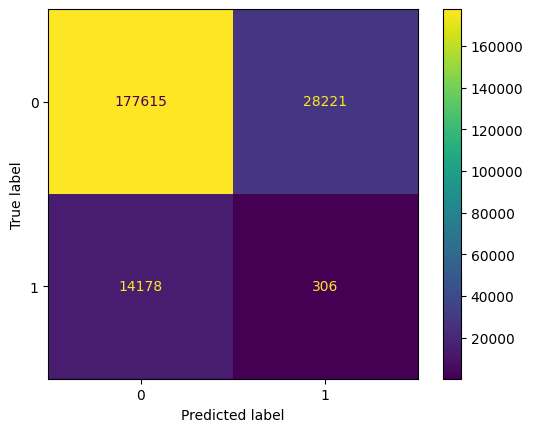

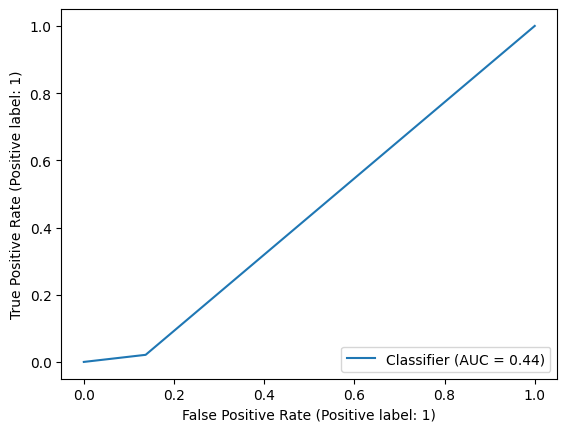

In [28]:
print(
    classification_report(
        predictions["machine_status"].values,
        predictions["anomaly_iqr"].values,
    )
)
ConfusionMatrixDisplay.from_predictions(
    predictions["machine_status"].values, predictions["anomaly_iqr"].values
)
plt.show()
RocCurveDisplay.from_predictions(
    predictions["machine_status"], predictions["anomaly_iqr"]
)
plt.show()

##### Evaluating the KMeans model

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    205836
           1       0.48      0.94      0.63     14484

    accuracy                           0.93    220320
   macro avg       0.74      0.94      0.80    220320
weighted avg       0.96      0.93      0.94    220320



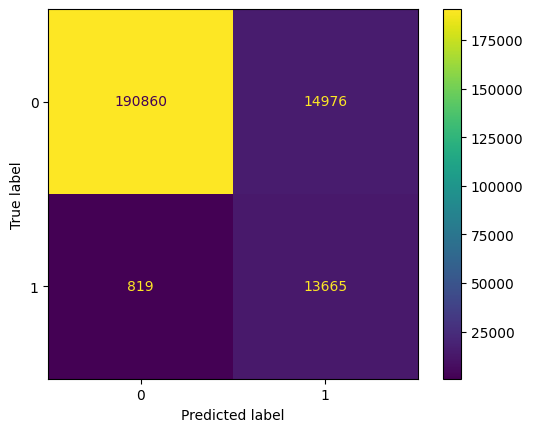

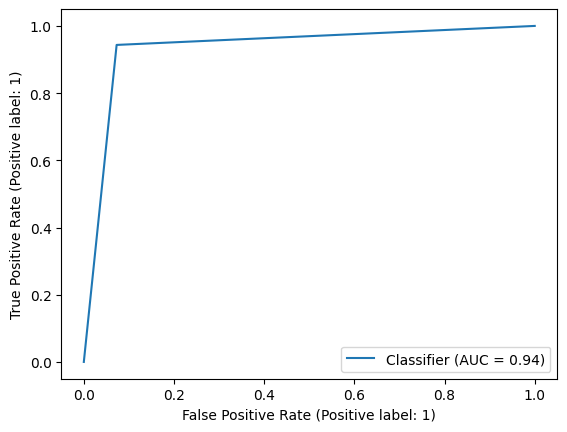

In [29]:
print(
    classification_report(
        predictions["machine_status"].values,
        predictions["anomaly_kmeans"].values,
    )
)
ConfusionMatrixDisplay.from_predictions(
    predictions["machine_status"].values, predictions["anomaly_kmeans"].values
)
plt.show()
RocCurveDisplay.from_predictions(
    predictions["machine_status"], predictions["anomaly_kmeans"]
)
plt.show()


##### Evaluating the Isolation Forest model

              precision    recall  f1-score   support

           0       0.97      0.91      0.94    205836
           1       0.32      0.64      0.43     14484

    accuracy                           0.89    220320
   macro avg       0.65      0.77      0.68    220320
weighted avg       0.93      0.89      0.90    220320



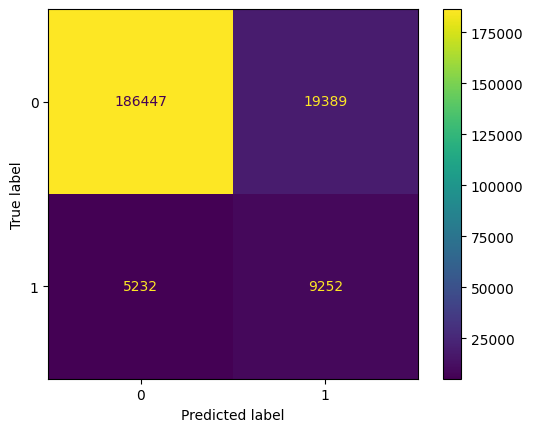

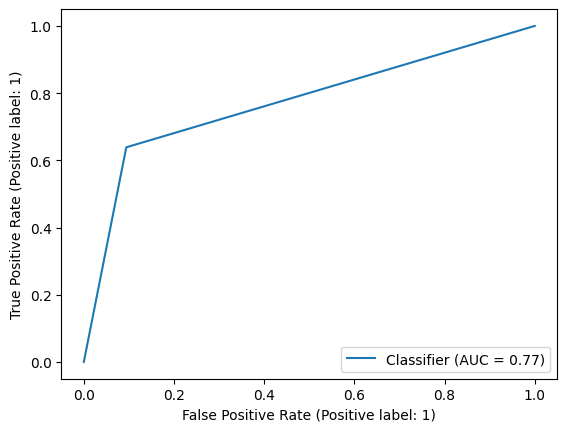

In [30]:
print(
    classification_report(
        predictions["machine_status"].values,
        predictions["anomaly_isoforest"].values,
    )
)
ConfusionMatrixDisplay.from_predictions(
    predictions["machine_status"].values, predictions["anomaly_isoforest"].values
)
plt.show()
RocCurveDisplay.from_predictions(
    predictions["machine_status"], predictions["anomaly_isoforest"]
)
plt.show()


From our evaluation, it appears clear that the KMeans model performs the best. Not only does it outperform our simple baseline model but also a model using the Isolation Forest approach. Undoubtably this is not the best model possible but it is a start. In production, we could use this model to live predict failure of the pump and act accordingly.